# Project: Train a Quadcopter How to Fly

Design an agent to fly a quadcopter, and then train it using a reinforcement learning algorithm of your choice! 

Try to apply the techniques you have learnt, but also feel free to come up with innovative ideas and test them.

## Instructions

Take a look at the files in the directory to better understand the structure of the project. 

- `task.py`: Define your task (environment) in this file.
- `agents/`: Folder containing reinforcement learning agents.
    - `policy_search.py`: A sample agent has been provided here.
    - `agent.py`: Develop your agent here.
- `physics_sim.py`: This file contains the simulator for the quadcopter.  **DO NOT MODIFY THIS FILE**.

For this project, you will define your own task in `task.py`.  Although we have provided a example task to get you started, you are encouraged to change it.  Later in this notebook, you will learn more about how to amend this file.

You will also design a reinforcement learning agent in `agent.py` to complete your chosen task.  

You are welcome to create any additional files to help you to organize your code.  For instance, you may find it useful to define a `model.py` file defining any needed neural network architectures.

## Controlling the Quadcopter

We provide a sample agent in the code cell below to show you how to use the sim to control the quadcopter.  This agent is even simpler than the sample agent that you'll examine (in `agents/policy_search.py`) later in this notebook!

The agent controls the quadcopter by setting the revolutions per second on each of its four rotors.  The provided agent in the `Basic_Agent` class below always selects a random action for each of the four rotors.  These four speeds are returned by the `act` method as a list of four floating-point numbers.  

For this project, the agent that you will implement in `agents/agent.py` will have a far more intelligent method for selecting actions!

In [1]:
%load_ext autoreload
%autoreload 2

import random
import csv
import numpy as np
from task import Task
import sys
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# logging and plotting utilities
import util

In [ ]:
import random

class Basic_Agent():
    def __init__(self, task):
        self.task = task
    
    def act(self):
        new_thrust = random.gauss(450., 25.)
        #rotor_speeds = [new_thrust + random.gauss(0., 1.) for x in range(4)]
        rotor_speeds = new_thrust *np.ones(4) # simplify model to use just 1 rotor speed for all 4 rotors
        #print(rotor_speeds)
        return rotor_speeds
    

Run the code cell below to have the agent select actions to control the quadcopter.  

Feel free to change the provided values of `runtime`, `init_pose`, `init_velocities`, and `init_angle_velocities` below to change the starting conditions of the quadcopter.

The `labels` list below annotates statistics that are saved while running the simulation.  All of this information is saved in a text file `data.txt` and stored in the dictionary `results`.  

In [ ]:
%load_ext autoreload
%autoreload 2

import csv
import numpy as np
from task import Task
from agents.policy_search import PolicySearch_Agent

# Modify the values below to give the quadcopter a different starting position.
runtime = 5.                                     # time limit of the episode
init_pose = np.array([0., 0., 50., 0., 0., 0.])  # initial pose np.array([0., 0., 10., 0., 0., 0.])
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
target_pos = np.array([0., 0., 30.])
file_output = 'data.txt'                         # file name for saved results

# Setup
task = Task(init_pose, init_velocities, init_angle_velocities, runtime, target_pos)
agent = Basic_Agent(task)
#agent = PolicySearch_Agent(task)
done = False
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4', 'reward']
results = {x : [] for x in labels}
# Run the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    
    while True:
        rotor_speeds = agent.act()
        state, reward, done = task.step(rotor_speeds)
        to_write = [task.sim.time]
        to_write += list(task.sim.pose)
        to_write += list(task.sim.v)
        to_write += list(task.sim.angular_v)
        to_write += list(rotor_speeds)
        to_write += [reward]
        
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        if done:
            break
            
util.plot_run(results)  # taken and modified from https://github.com/racersmith/RL_Quadcopter_2

When specifying a task, you will derive the environment state from the simulator.  Run the code cell below to print the values of the following variables at the end of the simulation:
- `task.sim.pose` (the position of the quadcopter in ($x,y,z$) dimensions and the Euler angles),
- `task.sim.v` (the velocity of the quadcopter in ($x,y,z$) dimensions), and
- `task.sim.angular_v` (radians/second for each of the three Euler angles).

In [ ]:
# the pose, velocity, and angular velocity of the quadcopter at the end of the episode
print(task.sim.pose)
print(task.sim.pose[3:])
print(task.sim.v)
print(task.sim.angular_v)

In the sample task in `task.py`, we use the 6-dimensional pose of the quadcopter to construct the state of the environment at each timestep.  However, when amending the task for your purposes, you are welcome to expand the size of the state vector by including the velocity information.  You can use any combination of the pose, velocity, and angular velocity - feel free to tinker here, and construct the state to suit your task.

## The Task

A sample task has been provided for you in `task.py`.  Open this file in a new window now. 

The `__init__()` method is used to initialize several variables that are needed to specify the task.  
- The simulator is initialized as an instance of the `PhysicsSim` class (from `physics_sim.py`).  
- Inspired by the methodology in the original DDPG paper, we make use of action repeats.  For each timestep of the agent, we step the simulation `action_repeats` timesteps.  If you are not familiar with action repeats, please read the **Results** section in [the DDPG paper](https://arxiv.org/abs/1509.02971).
- We set the number of elements in the state vector.  For the sample task, we only work with the 6-dimensional pose information.  To set the size of the state (`state_size`), we must take action repeats into account.  
- The environment will always have a 4-dimensional action space, with one entry for each rotor (`action_size=4`). You can set the minimum (`action_low`) and maximum (`action_high`) values of each entry here.
- The sample task in this provided file is for the agent to reach a target position.  We specify that target position as a variable.

The `reset()` method resets the simulator.  The agent should call this method every time the episode ends.  You can see an example of this in the code cell below.

The `step()` method is perhaps the most important.  It accepts the agent's choice of action `rotor_speeds`, which is used to prepare the next state to pass on to the agent.  Then, the reward is computed from `get_reward()`.  The episode is considered done if the time limit has been exceeded, or the quadcopter has travelled outside of the bounds of the simulation.

In the next section, you will learn how to test the performance of an agent on this task.

## The Agent

The sample agent given in `agents/policy_search.py` uses a very simplistic linear policy to directly compute the action vector as a dot product of the state vector and a matrix of weights. Then, it randomly perturbs the parameters by adding some Gaussian noise, to produce a different policy. Based on the average reward obtained in each episode (`score`), it keeps track of the best set of parameters found so far, how the score is changing, and accordingly tweaks a scaling factor to widen or tighten the noise.

Run the code cell below to see how the agent performs on the sample task.


init_pose:  [ 0.  0. 10.  0.  0.  0.]
init_velocities:  None
target_pos:  [ 0.  0. 20.]

action_range 700
self.w [[ -5.57675329]
 [ -2.49248964]
 [  6.52226821]
 [ -3.73911397]
 [  5.41652295]
 [ -7.32217406]
 [  3.43391597]
 [  9.34350032]
 [-16.01991806]
 [ -5.16506184]
 [  3.74028231]
 [ -1.31603491]
 [  2.40557511]
 [ -3.9147188 ]
 [  0.5612301 ]
 [ -1.00901912]
 [  7.56895781]
 [  1.64902398]]

Episode =    1, score =  -0.522 (best =  -0.522), noise_scale = 0.05

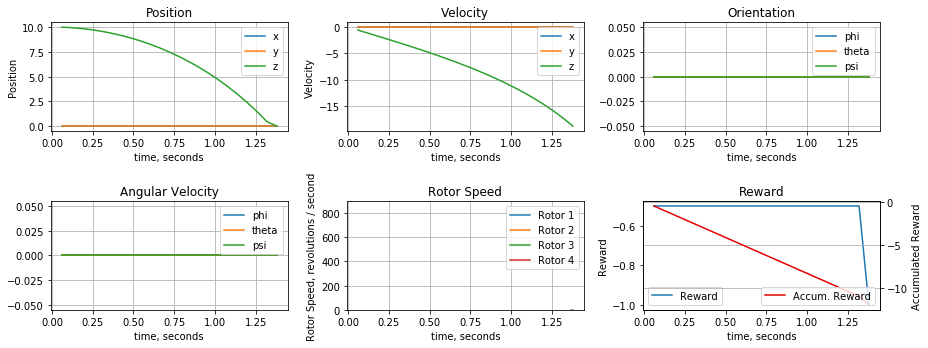

In [6]:
import sys
import pandas as pd
from agents.policy_search import PolicySearch_Agent
from task import Task

num_episodes = 50
init_pose = np.array([0.0, 0.0, 10., 0.0, 0.0, 0.0])
target_pos = np.array([0., 0., 20.])
task = Task(init_pose=init_pose, target_pos=target_pos) 
agent = PolicySearch_Agent(task)

for i_episode in range(1, num_episodes+1):

    state = agent.reset_episode() # start a new episode

    results = {x : [] for x in labels}
    # Run the simulation, and save the results.
    with open(file_output, 'w') as csvfile:
        
        writer = csv.writer(csvfile)
        writer.writerow(labels)
    
        while True:
            action = agent.act(state) 
            #print(action)
            next_state, reward, done = task.step(action)
            agent.step(reward, done)
            state = next_state
            if i_episode == num_episodes:
                to_write = [task.sim.time]
                to_write += list(task.sim.pose)
                to_write += list(task.sim.v)
                to_write += list(task.sim.angular_v)
                to_write += list(action * np.ones(4))   #rotor_speeds, use * np.ones(4) only if using action_space = 1
                to_write += [reward]
        
                for ii in range(len(labels)):
                    results[labels[ii]].append(to_write[ii])
                writer.writerow(to_write)
        
            # within the episode loop
        
            if done:
                # at the end of the episode, add the latest data points to the graph
                print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {}".format(
                    i_episode, agent.score, agent.best_score, agent.noise_scale), end="")  # [debug]         
                break
        sys.stdout.flush()
        
util.plot_run(results)  # taken and modified from https://github.com/racersmith/RL_Quadcopter_2

This agent should perform very poorly on this task.  And that's where you come in!

## Define the Task, Design the Agent, and Train Your Agent!

Amend `task.py` to specify a task of your choosing.  If you're unsure what kind of task to specify, you may like to teach your quadcopter to takeoff, hover in place, land softly, or reach a target pose.  

After specifying your task, use the sample agent in `agents/policy_search.py` as a template to define your own agent in `agents/agent.py`.  You can borrow whatever you need from the sample agent, including ideas on how you might modularize your code (using helper methods like `act()`, `learn()`, `reset_episode()`, etc.).

Note that it is **highly unlikely** that the first agent and task that you specify will learn well.  You will likely have to tweak various hyperparameters and the reward function for your task until you arrive at reasonably good behavior.

As you develop your agent, it's important to keep an eye on how it's performing. Use the code above as inspiration to build in a mechanism to log/save the total rewards obtained in each episode to file.  If the episode rewards are gradually increasing, this is an indication that your agent is learning.


init_pose:  [0. 0. 2. 0. 0. 0.]
init_velocities:  None
target_pos:  [ 0.  0. 10.]

setting policy update rate: 0.0001
setting policy update rate: 0.0001
setting value update rate: 0.001
setting value update rate: 0.001
Episode =   50

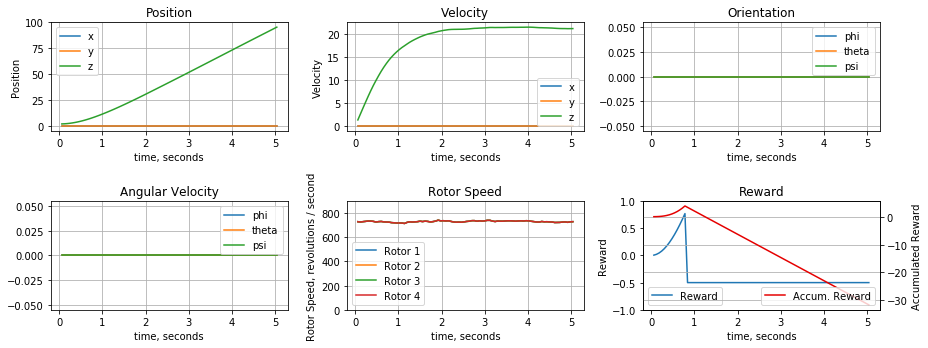

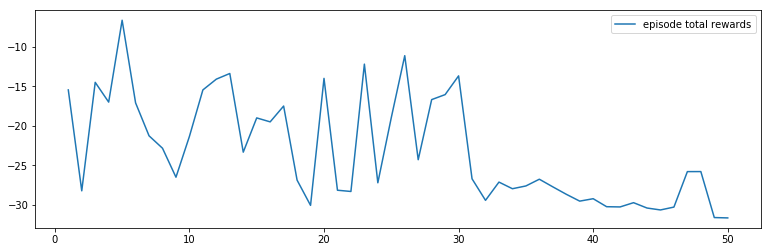

__________________________________________________________________________________________
Episode =  100

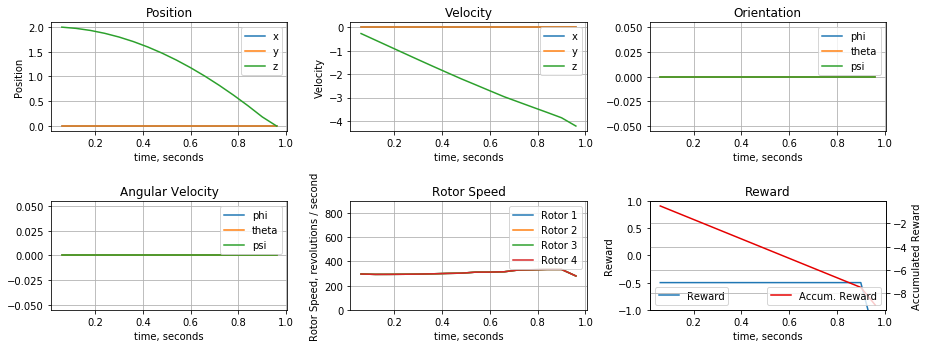

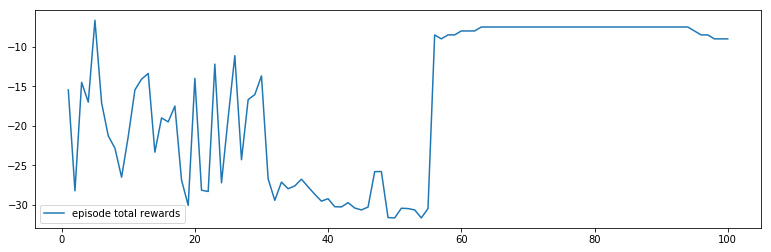

__________________________________________________________________________________________
Episode =  150

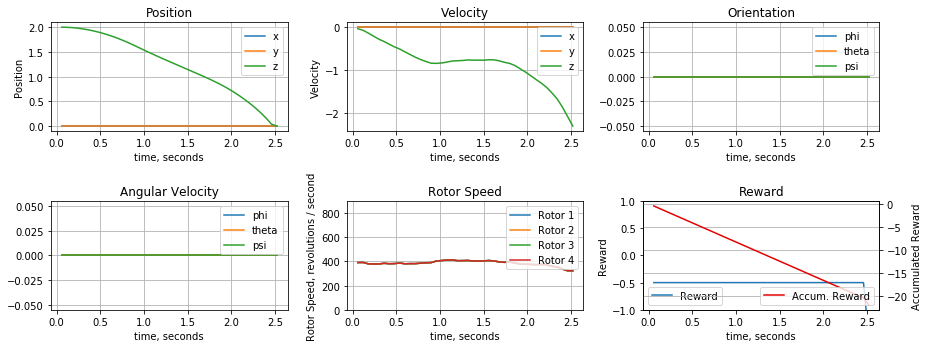

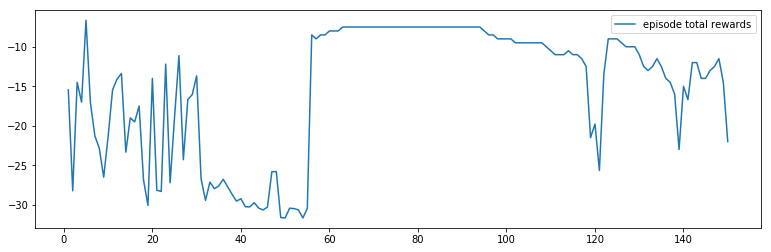

__________________________________________________________________________________________


In [40]:
import sys
import pandas as pd
#from agents.policy_search import PolicySearch_Agent
from agents.agent import DDPG
from task import Task

num_episodes = 150
init_pose = np.array([0.0, 0.0, 2.0, 0.0, 0.0, 0.0])
init_velocities = np.array([0.0, 0.0, 0.0])
target_pos = np.array([0., 0., 10.])
task = Task(init_pose=init_pose,
            #init_velocities=init_velocities,
            target_pos=target_pos) 
agent = DDPG(task)

# general configuration
display_graph = True
display_freq = 50
file_output = 'data.txt'                         # file name for saved results

labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4', 'reward']

total_rewards, total_rewards2 = [], []

for i_episode in range(1, num_episodes+1):
    
    results = {x : [] for x in labels}
    # Run the simulation, and save the results.
    with open(file_output, 'w') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(labels)

        state = agent.reset_episode() # start a new episode
        rewards = []
        while True:
            action = agent.act(state) 
            #for e in action:
            #    if (e < 200):
            #        print('action below minimum value(!):', action)
            next_state, reward, done = task.step(action)
            agent.step(action, reward, next_state, done)
            state = next_state
            rewards.append(reward)
            
            # within the episode loop
            if (i_episode % display_freq == 0):
                to_write = [task.sim.time]
                to_write += list(task.sim.pose)
                to_write += list(task.sim.v)
                to_write += list(task.sim.angular_v)
                to_write += list(action * np.ones(4))   #rotor_speeds, use * np.ones(4) only if using action_space = 1
                to_write += [reward]                
                for ii in range(len(labels)):
                    results[labels[ii]].append(to_write[ii])
                writer.writerow(to_write)        
                
            if done:
                # at the end of the episode, add the latest data points to the graph
                #print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {}".format(
                #    i_episode, agent.score, agent.best_score, agent.noise_scale), end="")  # [debug]
                
                print("\rEpisode = {:4d}".format(i_episode), end="")  # [debug]    
                
                total_rewards2.append(np.array(rewards).sum())
                
                if (i_episode % display_freq == 0 and display_graph == True):    
                    util.plot_run(results)
                    #plot episode rewards
                    plt.figure(figsize=(13,4))
                    plt.plot(range(1, i_episode + 1), total_rewards2, label='episode total rewards')
                    plt.legend()
                    plt.show()
                    print('__________________________________________________________________________________________')

                break
        sys.stdout.flush()

## Plot the Rewards

Once you are satisfied with your performance, plot the episode rewards, either from a single run, or averaged over multiple runs. 

In [ ]:
#plot episode rewards
plt.figure(figsize=(13,7))
plt.plot(range(1, num_episodes + 1), online_rewards, label='episode total rewards')
plt.legend()
plt.show()


## Reflections

**Question 1**: Describe the task that you specified in `task.py`.  How did you design the reward function?

**Answer**: 
In task.py the task class is loaded. It initializes the PhysicsSim model, action repeats, and sets the interface to the cuadcopter parameters. It also sets up the reward function. After the first trials I set the action space from 4 to 1. Now only 1 rotor speed is being used and the 4 rotor speeds needed by the sim are generateed with ```rotor speed * np.ones(4)```

This reduces complexity significantly, as the cuadcopter now only moves vertically and neiter movements in x nor y directions nor rolling / pitching or yawing are possible. At first I wanted to implement a hovering task for the quadcopter, but after not having any success, i tried the "startup" task, as it is said to be easier to learn.

The reward function is a composite function:

        if (self.sim.pose[2] < self.target_pos[2] + 1) and (self.sim.v[2] < 0):
            reward = -.5
        elif (self.sim.pose[2] > self.target_pos[2] - 1) and (self.sim.v[2] > 0):
            reward = -.5
        else:
            reward = 1. - .125 * (abs(self.target_pos[2] - self.sim.pose[2]))
            reward = np.clip(reward, -1, 1)
        # penalize crash
        if done and self.sim.time < self.sim.runtime:
            reward = -1
        return reward

I also thought about designing the reward function like a classical cascaded control structure (reward for position, then velocity and finally acceleration) but it would be too complex to understand and first there should be a simple and working reward function (to compare the complex solution against the simple one)

**Question 2**: Discuss your agent briefly, using the following questions as a guide:

- What learning algorithm(s) did you try? What worked best for you?
- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)?
- What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.

**Answer**: I took the DDPG algorithm (**Continuous Control with Deep Reinforcement Learning**). This is a model-free algorithm based on deterministic policy gradient which is especially suited to operate over continuous action spaces. (DDPG = Deep Deterministic Policy Gradient)

I tried to choose most of the parameters as indicated in the *experiment details* section in the DDPG paper https://arxiv.org/pdf/1509.02971.pdf. The learning rate parameters $\alpha$ for the actor and $\beta$ for the critic were set to 1e-4 and 1e-3 respectively. The discount rate for the rewards was set to $\gamma = 0.99$ and the learning rate for the soft target updates is set to $\tau = 0.001$ The actor-NN final output layer activation function was set to$\ sigmoid$, Although the DDPG paper states that $\tanh$ activations where used. When I tried the $\tanh$ activations, however, they led actions way below the defined minimum.

The NN architectures choosen for the hidden layers are:

- for the **actor**: 3 hidden layers with l2 regularization, batch-normalization and leakyReLu activations, sigmoid in the final (4th) layer

      net = layers.Dense(units=300, kernel_regularizer=regularizers.l2(1e-5))(states)
      net = layers.BatchNormalization()(net)
      net = layers.LeakyReLU(1e-2)(net)

      net = layers.Dense(units=400, kernel_regularizer=regularizers.l2(1e-5))(net)
      net = layers.BatchNormalization()(net)
      net = layers.LeakyReLU(1e-2)(net)

      net = layers.Dense(units=200, kernel_regularizer=regularizers.l2(1e-5))(net)
      net = layers.BatchNormalization()(net)
      net = layers.LeakyReLU(1e-2)(net)

- for the final layer$\ sigmoid$ was choosen as activation

      raw_actions = layers.Dense(units=self.action_size, activation='sigmoid', name='raw_actions')(net)    

- for the **critic**: 2 hidden layers for each state- and action pathway, with l2 regularization, batch-normalization and leakyReLu activations

      net_states / net_actions = layers.Dense(units=300, kernel_regularizer=regularizers.l2(1e-5))(states)
      net_states / net_actions = layers.BatchNormalization()(net_states)
      net_states / net_actions = layers.LeakyReLU(1e-2)(net_states)

      net_states / net_actions = layers.Dense(units=400, kernel_regularizer=regularizers.l2(1e-5))(net_states)
      net_states / net_actions = layers.BatchNormalization()(net_states)
      net_states / net_actions = layers.LeakyReLU(1e-2)(net_states)

- After combining the 2 nets, one more hidden layer was added:

      net = layers.Dense(units=200, kernel_regularizer=regularizers.l2(1e-5))(net)
      net = layers.BatchNormalization()(net)
      net = layers.LeakyReLU(1e-2)(net)

Experience replay is used to remove correlations between the <state-action-reward-next_state>-tuples (the flight "experiences" of the cuadcopter). In general it separates the learning- from the practicing process. First an existing value function is used to make experiences (practicing). Then these experiences are sampled randomly from the replay buffer and the value fct. is updated. After reducing the action space, I also reduced the replay buffer from 1e5 to 1e3. 

Ornstein-Uhlenbeck Noise describes the velocity of a Brownian particle under the influence of friction. Here, is used to make the policy search (and thus the flight path) more stochastic by adding noise to the actor's actions. $\mu$ is the mean reversion level, $\theta$ is the mean reversion speed and $\sigma$ denotes the diffusion.

Fixed Q-targets are used to prevent the critic network to change the target before an entire batch is processed. The parameter $\tau$ shifts the soft-update from using the local weights ($\tau = 1$) that are changed after each timestep, and using the target weights ($\tau = 0$) changed after each processed batch. In my implementation $\tau = 0.001$ as indicated in the DDPG paper. This means that the fixed-target weights are strongly preferred over the local (moving-target) weights.

**Question 3**: Using the episode rewards plot, discuss how the agent learned over time.

- Was it an easy task to learn or hard?
- Was there a gradual learning curve, or an aha moment?
- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)

**Answer**: 
The task is quite difficult to learn, especially when working with 4 different rotor speeds: the cuadcopter started spinning around 2 axes uncontrollably. After reducing action dims from 4 to 1, the flight behaviour became a lot more stable but until now the agent always appears to stop learning after a number of periods. While the agent appears to be responsive during the first episodes, it sticks more and more to its current policy, as episodes progress.

**Question 4**: Briefly summarize your experience working on this project. You can use the following prompts for ideas.

- What was the hardest part of the project? (e.g. getting started, plotting, specifying the task, etc.)
- Did you find anything interesting in how the quadcopter or your agent behaved?

**Answer**:
The hardest part was figuring out how to start. The DDPG algorithm is quite complex and with my current skills I had no possibility to figure out how if actor and critic network were actually leraning. I guess Tensorboard could help with that...